In [2]:
library(tidyverse)
library(broom)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


## Load cov matrix data

In [15]:
df = read_csv('all_dat.csv')

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  data_provider_index = col_integer(),
  img_index = col_integer(),
  label = col_character(),
  log_det = col_double(),
  log_det_scaled = col_double(),
  path = col_character(),
  train_or_test = col_character()
)


In [16]:
# remove rows with missing data
df = df[complete.cases(df), ]

# remove empty cols
drop_cols = c("X1")
df = select(df,-one_of(drop_cols))

# change data types of some cols
df %>%
    mutate(
        train_or_test=as.factor(train_or_test),
        label=as.factor(label)
    ) -> df

df %>%
    select(-log_det) ->
    df

In [17]:
df %>% head

data_provider_index,img_index,label,log_det_scaled,path,train_or_test
8213,9123,Lamin B1,-5.677829,3500000958_10X_20170606_4-Scene-07-P34-E07.czi_11,train
18120,20150,Tom20,-4.749293,3500000997_100X_20170621_2-Scene-01-P11-E05.czi_8,train
5167,5759,Lamin B1,-5.986030,3500000490_100X_20170127_E06_P14.czi_2,train
739,7251,Lamin B1,-5.669664,3500000876_100X_20170508_2-Scene-05-P15-E05.czi_12,test
9288,10321,ST6GAL1,-3.560406,3500001303_100X_20170918_e1-Scene-07-P19-E06.czi_1,train
7321,8128,Lamin B1,-6.376933,3500000924_100X_20170522_4-Scene-12-P50-F06.czi_12,train


## Merge in mitotic annotations

In [18]:
df_mito = read_csv("/root/aics/modeling/rorydm/data/dataset_cellnuc_seg_qc/ipp_17_10_31/data_jobs_out_mitotic_annotations.csv")

df_mito %>%
    rowwise() %>%
    mutate(path = paste(inputFilename,outputThisCellIndex,sep='_')) %>%
    select(path, MitosisLabel) ->
    df_mito

df_mito %>% 
    inner_join(df) ->
    df

df$MitosisLabel = as.factor(df$MitosisLabel)

df %>% write_csv('df_alldat_mito.csv')

Parsed with column specification:
cols(
  .default = col_character(),
  outputThisCellIndex = col_double(),
  MitosisLabel = col_double(),
  FinalScore = col_integer(),
  Index = col_double(),
  SegmentationXyPixelSize = col_double(),
  SegmentationZPixelSize = col_double(),
  Version = col_double(),
  imageXyPixelSize = col_double(),
  imageZPixelSize = col_double(),
  lightChannel = col_double(),
  memChannel = col_double(),
  nucChannel = col_double(),
  structureChannel = col_double(),
  timePoint = col_double()
)
See spec(...) for full column specifications.
Joining, by = "path"


In [19]:
df$MitosisLabel %>% table

.
   0    1    2    3    4    5    6    7 
6994   46   30   46   98   53   71  254 

In [20]:
df$BinaryMitosisLabel456 = as.factor((df$MitosisLabel %in% c(4,5,6)) + 0)
levels(df$BinaryMitosisLabel456) <- c("non-mitotic-456", "mitotic-456")
df$BinaryMitosisLabel456[is.na(df$MitosisLabel)] = NA
df$BinaryMitosisLabel456 %>% table

.
non-mitotic-456     mitotic-456 
           7370             222 

## Plots

Saving 6.67 x 6.67 in image


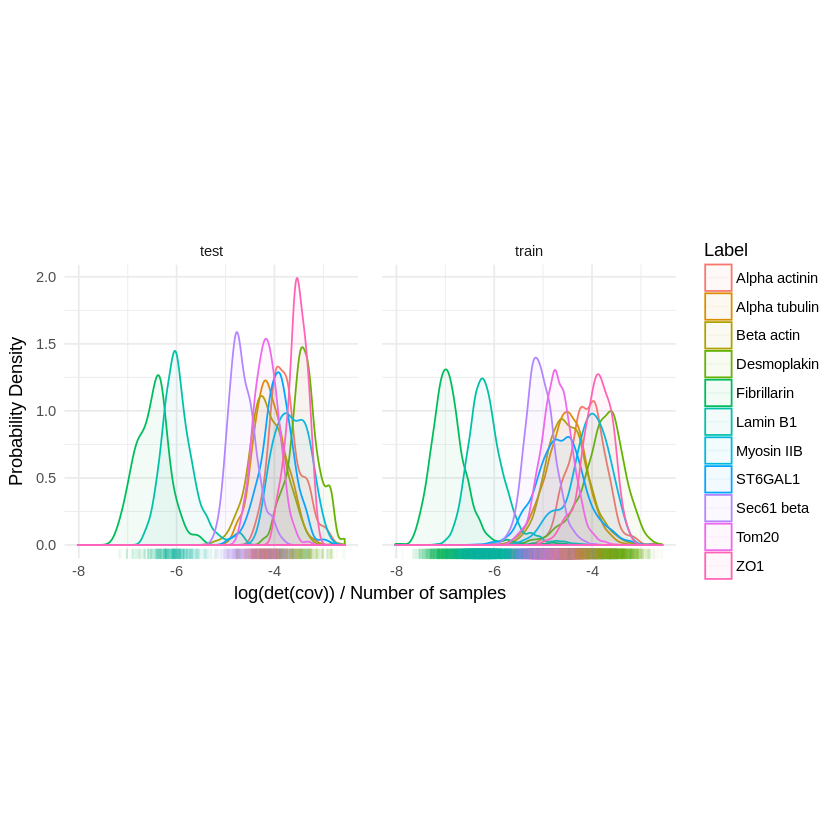

In [22]:
df %>%
    ggplot(aes(x=log_det_scaled, color=label, fill=label)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    facet_wrap(~train_or_test, scales = 'fixed') +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="log(det(cov)) / Number of samples", y= "Probability Density", color="Label", fill="Label") ->
    p

ggsave(p, filename = "logdetcov_train_test.png", device="png", dpi = 600)
p

Saving 6.67 x 6.67 in image


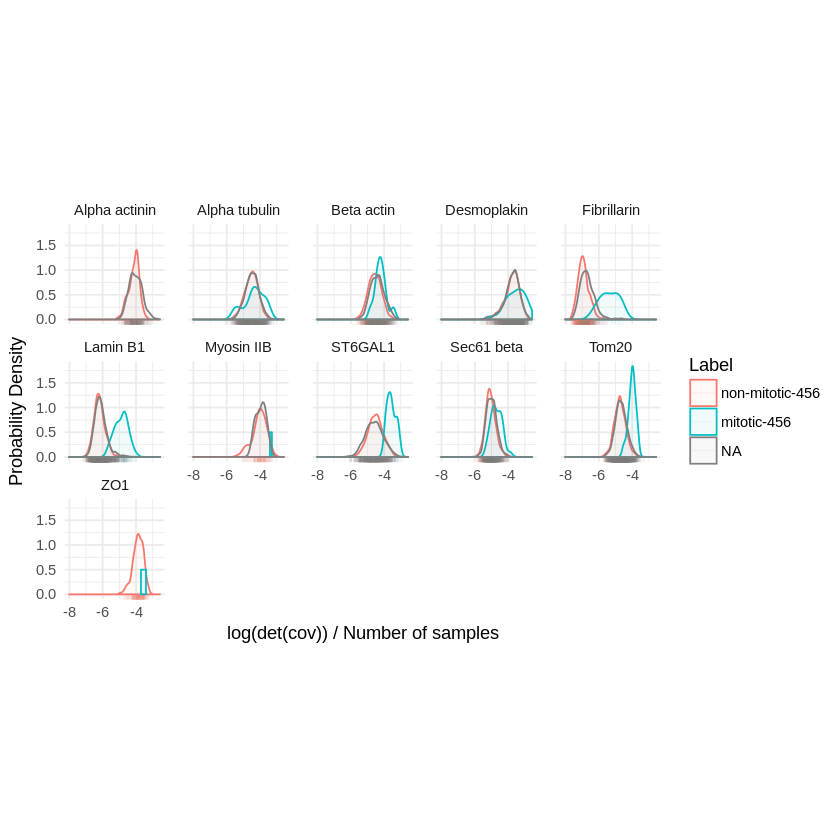

In [24]:
df %>%
    ggplot(aes(x=log_det_scaled, color=BinaryMitosisLabel456, fill=BinaryMitosisLabel456)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    facet_wrap(~label, scales = 'fixed', ncol = 5) +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="log(det(cov)) / Number of samples", y= "Probability Density", color="Label", fill="Label") ->
    p

ggsave(p, filename = "logdetcov_mito_by_class.png", device="png", dpi = 600)
p

Saving 6.67 x 6.67 in image


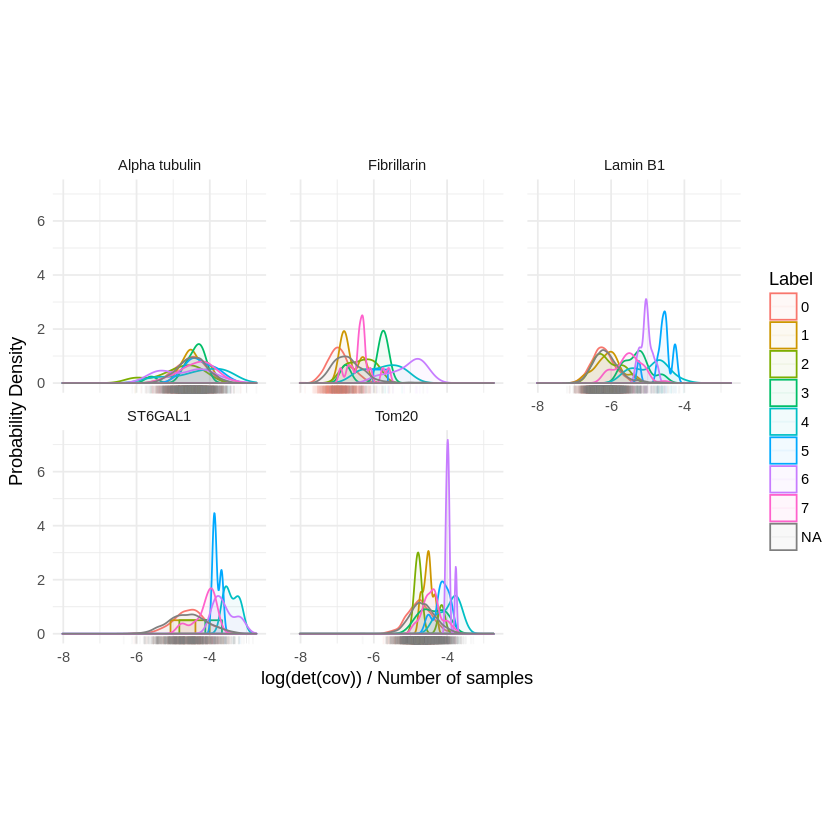

In [27]:
df %>%
    filter(label %in% c('Lamin B1', 'Alpha tubulin', 'Tom20', 'Fibrillarin', 'ST6GAL1')) %>%
    ggplot(aes(x=log_det_scaled, color=MitosisLabel, fill=MitosisLabel)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    facet_wrap(~label, scales = 'fixed', ncol = 3) +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
    labs(x="log(det(cov)) / Number of samples", y= "Probability Density", color="Label", fill="Label") ->
    p

ggsave(p, filename = "logdetcov_mitofull_by_class.png", device="png", dpi = 600)
p

## enrichment tests

In [32]:
# Can't sample too many or we run out of samples for the poorly sampled classes
N=8

# sort by best and worst
df %>%
    filter(!is.na(MitosisLabel)) %>%
    group_by(label, train_or_test) %>%
    top_n(N, log_det_scaled) %>%
    ungroup() ->
    df_best_preds

df %>%
    filter(!is.na(MitosisLabel)) %>%
    group_by(label, train_or_test) %>%
    top_n(N, desc(log_det_scaled)) %>%
    ungroup() ->
    df_worst_preds

# # label and combine
df_best_preds$Type = "best"
df_worst_preds$Type = "worst"
df_extremal_preds = rbind(df_best_preds, df_worst_preds)

# # write out
df_best_preds %>% write_csv("best_preds.csv")
df_worst_preds %>% write_csv("worst_preds.csv")
df_extremal_preds %>% write_csv("extremal_preds.csv")

Warning message:
"Grouping rowwise data frame strips rowwise nature"Warning message:
"Grouping rowwise data frame strips rowwise nature"

In [35]:
# split by test / train 

df_extremal_preds$Type = as.factor(df_extremal_preds$Type)

df_pval = data.frame()
for (label_i in levels(df_extremal_preds$label)) {
    
    df_extremal_preds %>%
        filter(label == label_i) %>%
        select(BinaryMitosisLabel456, Type) ->
        df_extremal_preds_tmp

    df_extremal_preds_tmp %>%
        filter(Type=='best') ->
        df_best_tmp

    df_extremal_preds_tmp %>%
        filter(Type=='worst') ->
        df_worst_tmp

    if (sum((df_extremal_preds_tmp$BinaryMitosisLabel456 == 'mitotic-456')
            [!is.na(df_extremal_preds_tmp$BinaryMitosisLabel456 == 'mitotic-456')]) > 0) {
        test_out = chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456,
                              df_extremal_preds_tmp$Type, correct=FALSE) %>%
                              tidy

        test_out$label = label_i
        df_pval = rbind(df_pval,test_out)
    }
}

df_pval$p.value.bonf = df_pval$p.value*length(levels(df_extremal_preds$label))

Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456, df_extremal_preds_tmp$Type, :
"Chi-squared approximation may be incorrect"Warning message in chisq.test(df_extremal_preds_tmp$BinaryMitosisLabel456, df_extremal_preds_tmp$Type, :
"

In [36]:
df_pval

statistic,p.value,parameter,method,label,p.value.bonf
3.864734,4.931100e-02,1,Pearson's Chi-squared test,Alpha tubulin,0.5424210096
1.032258,3.096289e-01,1,Pearson's Chi-squared test,Beta actin,3.4059179300
7.384615,6.578414e-03,1,Pearson's Chi-squared test,Desmoplakin,0.0723625497
8.960000,2.759549e-03,1,Pearson's Chi-squared test,Fibrillarin,0.0303550383
16.761905,4.237556e-05,1,Pearson's Chi-squared test,Lamin B1,0.0004661311
2.133333,1.441270e-01,1,Pearson's Chi-squared test,Myosin IIB,1.5853973830
5.925926,1.491970e-02,1,Pearson's Chi-squared test,ST6GAL1,0.1641166594
3.310345,6.884504e-02,1,Pearson's Chi-squared test,Sec61 beta,0.7572954907
7.384615,6.578414e-03,1,Pearson's Chi-squared test,Tom20,0.0723625497
1.032258,3.096289e-01,1,Pearson's Chi-squared test,ZO1,3.4059179300
